In [1]:
import numpy as np
import SimpleITK as sitk
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# DATA


## GET DATA

In [2]:
from glob import glob
from typing import  List

In [3]:
BUY_file_paths =  sorted(glob("./SEGMENTED/BUY/*.nii.gz"))  #68 files
EAT_file_paths =  sorted(glob("./SEGMENTED/EAT/*.nii.gz"))  #85 files
GAMBLE_file_paths =  sorted(glob("./SEGMENTED/GAMBLE/*.nii.gz")) #7 files
SEX_file_paths =  sorted(glob("./SEGMENTED/SEX/*.nii.gz"))  #42 files

PD_file_paths =  sorted(glob("./SEGMENTED/PD/*.nii.gz"))  #100 files

In [4]:
BUY_file_paths =  sorted(glob("./PREPROCESSED/BUY/*.nii.gz"))  #42 files
EAT_file_paths =  sorted(glob("./PREPROCESSED/EAT/*.nii.gz"))  #81 files
GAMBLE_file_paths =  sorted(glob("./PREPROCESSED/GAMBLE/*.nii.gz")) #7 files
SEX_file_paths =  sorted(glob("./PREPROCESSED/SEX/*.nii.gz"))  #22 files

PD_file_paths =  sorted(glob("./PREPROCESSED/PD/*.nii.gz"))  #116 files

In [5]:
print(len(BUY_file_paths), BUY_file_paths[:3])
print(len(EAT_file_paths), EAT_file_paths[:3])
print(len(GAMBLE_file_paths), GAMBLE_file_paths[:3])
print(len(SEX_file_paths), SEX_file_paths[:3])

print(len(PD_file_paths), PD_file_paths[:3])

42 ['./PREPROCESSED/BUY\\3018.nii.gz', './PREPROCESSED/BUY\\3062.nii.gz', './PREPROCESSED/BUY\\3168.nii.gz']
81 ['./PREPROCESSED/EAT\\3002.nii.gz', './PREPROCESSED/EAT\\3023.nii.gz', './PREPROCESSED/EAT\\3062.nii.gz']
7 ['./PREPROCESSED/GAMBLE\\3536.nii.gz', './PREPROCESSED/GAMBLE\\3565.nii.gz', './PREPROCESSED/GAMBLE\\3863.nii.gz']
22 ['./PREPROCESSED/SEX\\3062.nii.gz', './PREPROCESSED/SEX\\3068.nii.gz', './PREPROCESSED/SEX\\3073.nii.gz']
116 ['./PREPROCESSED/PD\\3006.nii.gz', './PREPROCESSED/PD\\3012.nii.gz', './PREPROCESSED/PD\\3014.nii.gz']


## SPLIT DATA

In [6]:
X_dataset = []
y_dataset = []

X_dataset.extend(PD_file_paths), y_dataset.extend([1] * len(PD_file_paths))
X_dataset.extend(BUY_file_paths), y_dataset.extend([2] * len(BUY_file_paths))
X_dataset.extend(EAT_file_paths), y_dataset.extend([3] * len(EAT_file_paths))
X_dataset.extend(GAMBLE_file_paths), y_dataset.extend([4] * len(GAMBLE_file_paths))
X_dataset.extend(SEX_file_paths), y_dataset.extend([5] * len(SEX_file_paths))

(None, None)

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, test_size = 0.2, stratify=y_dataset)

In [8]:
print("Dataset:", len(X_dataset), len(y_dataset))
print("Train:", len(X_train), len(y_train))
print("Test:", len(X_test), len(y_test))

Dataset: 268 268
Train: 214 214
Test: 54 54


## PREPROSSESING

In [173]:
def get_category(category, is_binary = True):
  result = np.zeros(2 if is_binary else 5)
  if is_binary:
    return 1 if category == 1 else 0
  elif category == 1:
    result[0] = 1
  else:
    result[category-1] = 1
  return result

In [174]:
def get_categories(y_data):
  categories = None
  is_first = True
  for category in y_data:
    if is_first:
      categories = np.array([get_category(category)])
      is_first = False
    else:
      categories = np.concatenate((categories,[get_category(category)]))
  return categories

In [176]:
print(get_category(5, True), get_category(5, False))
print(get_category(1, True), get_category(1, False))

0 [0. 0. 0. 0. 1.]
1 [1. 0. 0. 0. 0.]


## 3D All Brain

In [12]:
import cv2
import cv2

dimension = 180
def get_slices_3d_all(path, category):
    img = sitk.ReadImage(path, sitk.sitkFloat64)
    arr = sitk.GetArrayFromImage(img)

    #normalize the matrix, numbers between 0.0 - 1.0
    arr = arr / arr.max()
    
    slice = arr[10:160, : , :]
    
    arr = np.zeros([150, dimension,dimension])
    
    for i in range(arr.shape[0]):
        arr[i, : , :] = cv2.resize(slice[i, : , :], (dimension, dimension), interpolation=cv2.INTER_CUBIC)
    
    slices = np.array([arr])
    slices = slices.reshape(1,arr.shape[0], arr.shape[1], arr.shape[2], 1)
    slices_cat = np.array([get_category(category)])
    
    return slices, slices_cat

In [13]:
def get_slices_per_group_3d_all(paths, categories):
    group = None
    group_cat = None

    count = 1
    for i in range(len(paths)):
        path = paths[i]
        try:
            if i == 0:
                group, group_cat = get_slices_3d_all(path, categories[i])
            else:
                new_group, new_group_cat = get_slices_3d_all(path, categories[i])
                group = np.concatenate((group, new_group))
                group_cat = np.concatenate((group_cat, new_group_cat))

            print("-> [%d/%d] Image processed." %(count,len(paths)))
            count+=1
        except:
            print("Error in", path)
    return group, group_cat

In [14]:
#test with one image
slices, slices_cat = get_slices_3d_all(X_dataset[11], y_dataset[0])
print(slices.shape)
print(slices_cat.shape)

(1, 150, 180, 180, 1)
(1,)


In [15]:
slices, slices_cat = get_slices_per_group_3d_all(X_dataset[:3], y_dataset[:3])
print(slices.shape)
print(slices_cat.shape)

-> [1/3] Image processed.
-> [2/3] Image processed.
-> [3/3] Image processed.
(3, 150, 180, 180, 1)
(3,)


## 3D

In [16]:
import cv2

dimension = 180
def get_slices_3d(path, category):
    img = sitk.ReadImage(path, sitk.sitkFloat64)
    arr = sitk.GetArrayFromImage(img)

    #normalize the matrix, numbers between 0.0 - 1.0
    arr = arr / arr.max()
    
    slice = arr[27:68, : , :]
    
    arr = np.zeros([32, dimension,dimension])
    
    for i in range(arr.shape[0]):
        arr[i, : , :] = cv2.resize(slice[i, : , :], (dimension, dimension), interpolation=cv2.INTER_CUBIC)
    
    slices = np.array([arr])
    slices = slices.reshape(1,arr.shape[0], arr.shape[1], arr.shape[2], 1)
    slices_cat = np.array([get_category(category)])
    
    return slices, slices_cat

In [17]:
def get_slices_per_group_3d(paths, categories):
    group = None
    group_cat = None

    count = 1
    for i in range(len(paths)):
        path = paths[i]
        if i == 0:
            group, group_cat = get_slices_3d(path, categories[i])
        else:
            new_group, new_group_cat = get_slices_3d(path, categories[i])
            group = np.concatenate((group, new_group))
            group_cat = np.concatenate((group_cat, new_group_cat))

        print("-> [%d/%d] Image processed." %(count,len(paths)))
        count+=1
    return group, group_cat

In [18]:
#test with one image
slices, slices_cat = get_slices_3d(X_dataset[0], y_dataset[0])
print(slices.shape)
print(slices_cat.shape)

(1, 32, 180, 180, 1)
(1,)


In [19]:
slices, slices_cat = get_slices_per_group_3d(X_dataset[:3], y_dataset[:3])
print(slices.shape)
print(slices_cat.shape)

-> [1/3] Image processed.
-> [2/3] Image processed.
-> [3/3] Image processed.
(3, 32, 180, 180, 1)
(3,)


## AXIAL (3 channels)
arr[ xxx , : , : ] axial

In [20]:
import cv2

SLICE_NUMBER = 50
def get_slices_axial_3c(path, category):
  img = sitk.ReadImage(path, sitk.sitkFloat64)
  arr = sitk.GetArrayFromImage(img)

  #normalize the matrix, numbers between 0.0 - 1.0
  arr = arr / arr.max()

  slices = None
  slices_cat = None
  count = 0

  for i in range(arr.shape[0]):
    slice = arr[arr.shape[0] - i -1, : , : ]
    slice = cv2.resize(slice, (224, 224), interpolation=cv2.INTER_CUBIC)
    slice[slice < 0] = 0
    if slice.max() != 0:
        slice = cv2.merge((slice,slice,slice))
        if count == 0:
            slices = np.array([slice])
            slices_cat = np.array([get_category(category)])
        if count < SLICE_NUMBER:
            slices = np.concatenate((slices,[slice]))
            slices_cat = np.concatenate((slices_cat,[get_category(category)]))
        count+=1
  #print("->", count , "slices of", arr.shape[0], "where used for image", path)
  return slices, slices_cat

In [21]:
def get_slices_per_group_axial_3c(paths, categories):
  group = None
  group_cat = None

  count = 1
  for i in range(len(paths)):
    path = paths[i]
    if i == 0:
      group, group_cat = get_slices_axial_3c(path, categories[i])
    else:
      new_group, new_group_cat = get_slices_axial_3c(path, categories[i])
      group = np.concatenate((group, new_group))
      group_cat = np.concatenate((group_cat, new_group_cat))

    print("-> [%d/%d] Slices processed %d." %(count,len(paths), group.shape[0] ))
    count+=1
  return group, group_cat

In [22]:
#test with one image
i = 3
slices, slices_cat = get_slices_per_group_axial_3c(X_dataset[0:i], y_dataset[0:i])
print(slices.shape)
print(slices_cat.shape)

-> [1/3] Slices processed 51.
-> [2/3] Slices processed 102.
-> [3/3] Slices processed 153.
(153, 224, 224, 3)
(153,)


## AXIAL
arr[ xxx , : , : ] axial

In [23]:
import cv2

SLICE_NUMBER = 50
def get_slices_axial(path, category):
  img = sitk.ReadImage(path, sitk.sitkFloat64)
  arr = sitk.GetArrayFromImage(img)

  #normalize the matrix, numbers between 0.0 - 1.0
  arr = arr / arr.max()

  slices = None
  slices_cat = None
  count = 0

  for i in range(arr.shape[0]):
    slice = arr[arr.shape[0] - i -1, : , : ]
    slice = cv2.resize(slice, (120, 120), interpolation=cv2.INTER_CUBIC)
    slice[slice < 0] = 0
    if slice.max() != 0:
      if count == 0:
        slices = np.array([slice])
        slices_cat = np.array([get_category(category)])
      if count < SLICE_NUMBER:
        slices = np.concatenate((slices,[slice]))
        slices_cat = np.concatenate((slices_cat,[get_category(category)]))
      count+=1
  #print("->", count , "slices of", arr.shape[0], "where used for image", path)
  return slices, slices_cat

In [24]:
def get_slices_per_group_axial(paths, categories):
  group = None
  group_cat = None

  count = 1
  for i in range(len(paths)):
    path = paths[i]
    if i == 0:
      group, group_cat = get_slices_axial(path, categories[i])
    else:
      new_group, new_group_cat = get_slices_axial(path, categories[i])
      group = np.concatenate((group, new_group))
      group_cat = np.concatenate((group_cat, new_group_cat))

    print("-> [%d/%d] Slices processed %d." %(count,len(paths), group.shape[0] ))
    count+=1
  return group, group_cat

In [25]:
#test with one image
slices, slices_cat = get_slices_axial(X_dataset[0], y_dataset[0])
print(slices.shape)
print(slices_cat.shape)

(51, 120, 120)
(51,)


## CORONAL
arr[ : , xxx , : ] coronal 

In [26]:
import cv2
# type: the number of the group
# group_n: the count of diferent groups
# for example,we can have the groups 
#    1) [EAT, GAMBLE, SEX, BUY, PURE] and the image is from GAMBLE
#     -> type = 2
#     -> group_n = 5
#    2) or [PURE, ICD] and the image is from PURE
#     -> type = 1
#     -> group_n = 2
#output:
#     -> normalized array of the slices 
#     -> the category of each image in one-hot encoded.
# for example
#   1) [0,1,0,0,0], and 
#   2) [1,0]
def get_slices_coronal(path, category):
  img = sitk.ReadImage(path, sitk.sitkFloat64)
  arr = sitk.GetArrayFromImage(img)

  #normalize the matrix, numbers between 0.0 - 1.0
  arr = arr / arr.max()

  slices = None
  slices_cat = None
  count = 0

  for i in range(arr.shape[0]):
    slice = arr[:, i , : ]
    slice = cv2.resize(slice, (224, 224), interpolation=cv2.INTER_CUBIC)
    slice[slice < 0] = 0
    if slice.max() != 0:
      if count == 0:
        slices = np.array([slice])
        slices_cat = np.array([get_category(category)])
      else:
        slices = np.concatenate((slices,[slice]))
        slices_cat = np.concatenate((slices_cat,[get_category(category)]))
      count+=1
  #print("->", count , "slices of", arr.shape[0], "where used for image", path)
  return slices, slices_cat

In [27]:
def get_slices_per_group_coronal(paths, categories):
  group = None
  group_cat = None

  count = 1
  for i in range(len(paths)):
    path = paths[i]
    if i == 0:
      group, group_cat = get_slices_coronal(path, categories[i])
    else:
      new_group, new_group_cat = get_slices_coronal(path, categories[i])
      group = np.concatenate((group, new_group))
      group_cat = np.concatenate((group_cat, new_group_cat))

    print("-> [%d/%d] Slices processed %d." %(count,len(paths), group.shape[0] ))
    count+=1
  return group, group_cat

In [28]:
#test with one image
slices, slices_cat = get_slices_coronal(X_dataset[0], y_dataset[0])
print(slices.shape)
print(slices_cat.shape)

(166, 224, 224)
(166,)


## SAGITAL
arr[ : , : , xxx ] sagital 

In [29]:
import cv2
# type: the number of the group
# group_n: the count of diferent groups
# for example,we can have the groups 
#    1) [EAT, GAMBLE, SEX, BUY, PURE] and the image is from GAMBLE
#     -> type = 2
#     -> group_n = 5
#    2) or [PURE, ICD] and the image is from PURE
#     -> type = 1
#     -> group_n = 2
#output:
#     -> normalized array of the slices 
#     -> the category of each image in one-hot encoded.
# for example
#   1) [0,1,0,0,0], and 
#   2) [1,0]
def get_slices_sagital(path, category):
  img = sitk.ReadImage(path, sitk.sitkFloat64)
  arr = sitk.GetArrayFromImage(img)

  #normalize the matrix, numbers between 0.0 - 1.0
  arr = arr / arr.max()

  slices = None
  slices_cat = None
  count = 0

  for i in range(arr.shape[0]):
    slice = arr[:, : , i ]
    slice = cv2.resize(slice, (224, 224), interpolation=cv2.INTER_CUBIC)
    slice[slice < 0] = 0
    if slice.max() != 0:
      if count == 0:
        slices = np.array([slice])
        slices_cat = np.array([get_category(category)])
      else:
        slices = np.concatenate((slices,[slice]))
        slices_cat = np.concatenate((slices_cat,[get_category(category)]))
      count+=1
  #print("->", count , "slices of", arr.shape[0], "where used for image", path)
  return slices, slices_cat

In [30]:
def get_slices_per_group_sagital(paths, categories):
  group = None
  group_cat = None

  count = 1
  for i in range(len(paths)):
    path = paths[i]
    if i == 0:
      group, group_cat = get_slices_sagital(path, categories[i])
    else:
      new_group, new_group_cat = get_slices_sagital(path, categories[i])
      group = np.concatenate((group, new_group))
      group_cat = np.concatenate((group_cat, new_group_cat))

    print("-> [%d/%d] Slices processed %d." %(count,len(paths), group.shape[0] ))
    count+=1
  return group, group_cat

In [31]:
#test with one image
slices, slices_cat = get_slices_sagital(X_dataset[0], y_dataset[0])
print(slices.shape)
print(slices_cat.shape)

(153, 224, 224)
(153,)


# MODEL (BINARY)

## Axial (Enssemble)

In [249]:
import os
import numpy as np
np.random.seed(777)
import math
import tensorflow as tf
import keras
import keras.backend as K
import h5py
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from keras.models import Sequential
from keras.models import Model
from keras.layers import Input, Activation, merge, Dense, Flatten, Dropout, concatenate
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import BatchNormalization, add, GlobalAveragePooling2D
from keras.utils.np_utils import to_categorical
from sklearn.metrics import accuracy_score,roc_curve, confusion_matrix, roc_auc_score, auc, f1_score
from keras.regularizers import l2
from keras.applications.xception import Xception, preprocess_input
from keras.applications.mobilenet import MobileNet
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.applications import DenseNet121

from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, Lambda,Concatenate
from keras.layers import SeparableConv2D, AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D, Add

import matplotlib.pyplot as plt

plt.rcParams["axes.grid"] = False
plt.rcParams.update({'font.size': 20})

In [178]:
X_axial3c_train, y_axial3c_train = get_slices_per_group_axial_3c(X_train, y_train)

-> [1/10] Slices processed 51.
-> [2/10] Slices processed 102.
-> [3/10] Slices processed 153.
-> [4/10] Slices processed 204.
-> [5/10] Slices processed 255.
-> [6/10] Slices processed 306.
-> [7/10] Slices processed 357.
-> [8/10] Slices processed 408.
-> [9/10] Slices processed 459.
-> [10/10] Slices processed 510.


In [221]:
X_axial3c_test, y_axial3c_test = get_slices_per_group_axial_3c(X_test, y_test)

-> [1/10] Slices processed 51.
-> [2/10] Slices processed 102.
-> [3/10] Slices processed 153.
-> [4/10] Slices processed 204.
-> [5/10] Slices processed 255.
-> [6/10] Slices processed 306.
-> [7/10] Slices processed 357.
-> [8/10] Slices processed 408.
-> [9/10] Slices processed 459.
-> [10/10] Slices processed 510.


In [180]:
print(X_axial3c_train.shape, y_axial3c_train.shape)
print(X_axialec_test.shape, y_axial3c_test.shape)

(510, 224, 224, 3) (510,)
(102, 224, 224, 3) (102,)


In [185]:
img_height, img_width = 224, 224
input_shape = (img_height, img_width, 3)
epochs = 1000
num_classes = 1

In [186]:
from tensorflow.keras.applications import VGG19

input_tensor = Input(shape = input_shape)  

base_model =VGG19(input_shape= input_shape,weights='imagenet', include_top=False, input_tensor=input_tensor)

x = base_model.output
x = GlobalAveragePooling2D()(x)

predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=input_tensor,outputs=predictions)

In [187]:
from keras.applications.densenet import DenseNet169
from keras.applications.inception_v3 import InceptionV3
from keras.applications.nasnet import NASNetMobile
from tensorflow.keras.applications import VGG19

input_tensor = Input(shape = input_shape)  

base_model1=NASNetMobile(input_shape= input_shape,weights='imagenet', include_top=False, input_tensor=input_tensor)
base_model2=InceptionV3(input_shape= input_shape,weights='imagenet', include_top=False, input_tensor=input_tensor)
base_model3=DenseNet201(input_shape= input_shape,weights='imagenet', include_top=False, input_tensor=input_tensor)
base_model4=VGG19(input_shape= input_shape,weights='imagenet', include_top=False, input_tensor=input_tensor)

x1 = base_model1.output
x1 = GlobalAveragePooling2D()(x1)

x2 = base_model2.output
x2 = GlobalAveragePooling2D()(x2)

x3 = base_model3.output
x3 = GlobalAveragePooling2D()(x3)

x4 = base_model4.output
x4 = GlobalAveragePooling2D()(x4)

merge = concatenate([x1, x2, x3 , x4])
predictions = Dense(1, activation='softmax')(merge)

model = Model(inputs=input_tensor,outputs=predictions)

In [188]:
bottleneck_final_model = Model(inputs=model.input, outputs=merge)

In [189]:
# training call backs 
lr_reduce = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, epsilon=0.0001, patience=3, verbose=1)
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1)

In [245]:
batch_size = 10
epochs = 1000
dropout_rate = 0.5

model = Sequential()
model.add(Flatten(input_shape=X_axial3c_train.shape[1:]))
model.add(Dense(256, activation='relu'))
model.add(Dropout(dropout_rate))
model.add(Dense(num_classes, activation=tf.nn.sigmoid))

adam_opt2=Adam(lr = 0.0001, beta_1=0.7, beta_2=0.995, amsgrad=True)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),loss=keras.losses.binary_crossentropy,metrics=['accuracy'])

history = model.fit(X_axial3c_train, y_axial3c_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[lr_reduce, es_callback],
                    validation_split=0.2,
                    verbose= 2)

c:\python39\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/1000
41/41 - 14s - loss: 1.2483 - accuracy: 0.6005 - val_loss: 0.5307 - val_accuracy: 0.7353
Epoch 2/1000
41/41 - 13s - loss: 0.5727 - accuracy: 0.7672 - val_loss: 0.9702 - val_accuracy: 0.2745
Epoch 3/1000
41/41 - 13s - loss: 0.3819 - accuracy: 0.8407 - val_loss: 1.3252 - val_accuracy: 0.2255
Epoch 4/1000
41/41 - 15s - loss: 0.2956 - accuracy: 0.9044 - val_loss: 0.7740 - val_accuracy: 0.6078

Epoch 00004: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
Epoch 5/1000
41/41 - 14s - loss: 0.2298 - accuracy: 0.9387 - val_loss: 1.2391 - val_accuracy: 0.3235
Epoch 6/1000
41/41 - 15s - loss: 0.1822 - accuracy: 0.9681 - val_loss: 0.8664 - val_accuracy: 0.5882
Epoch 00006: early stopping


In [246]:
model.summary()

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 150528)            0         
_________________________________________________________________
dense_60 (Dense)             (None, 256)               38535424  
_________________________________________________________________
dropout_21 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_61 (Dense)             (None, 1)                 257       
Total params: 38,535,681
Trainable params: 38,535,681
Non-trainable params: 0
_________________________________________________________________


In [247]:
preds = model.predict(X_axial3c_test)

predictions = [(0 if i <0.5 else 1) for i in preds]
cm = confusion_matrix(y_pred=predictions, y_true=y_axial3c_test)

print('Accuracy {}'.format(accuracy_score(y_true=y_axial3c_test, y_pred=predictions)))

Accuracy 0.6254901960784314


Confusion Matrix
[[145 110]
 [ 81 174]]


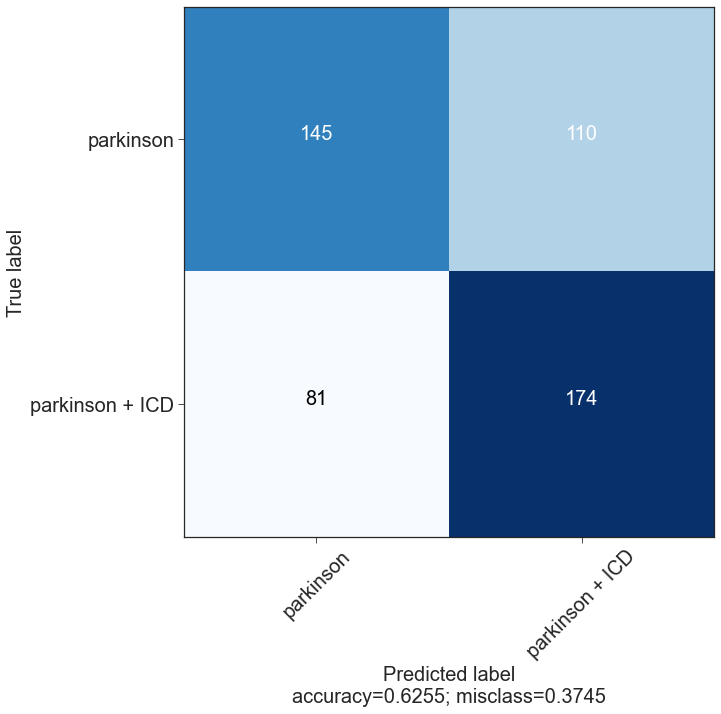

In [248]:
plt.rcParams["axes.grid"] = False
plt.rcParams.update({'font.size': 20})

labels = ['parkinson', "parkinson + ICD"]

from sklearn.metrics import confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion Matrix')

    print(cm)
#     fig = plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
#     plt.title(title)
#     plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.savefig('confusion_marix.png', bbox_inches='tight', dpi = 100) 


plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, classes=labels, title=' ')

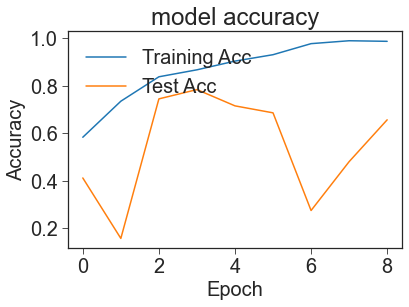

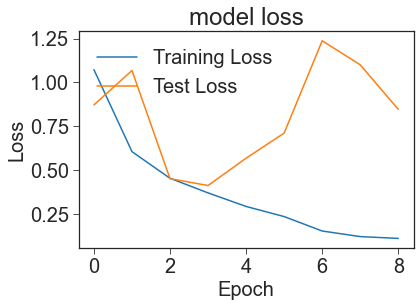

<Figure size 432x288 with 0 Axes>

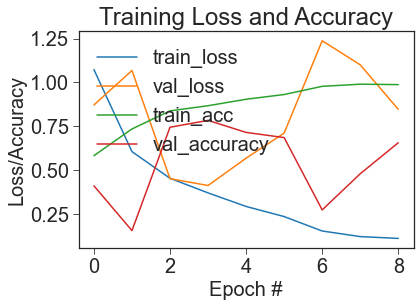

In [225]:
plt.style.use("seaborn-ticks")

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Acc', 'Test Acc'], loc='upper left')
plt.show()
plt.savefig('model_acc.png', bbox_inches='tight', dpi = 100) 

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Test Loss'], loc='upper left')
plt.show()
plt.savefig('model_pogress.png', bbox_inches='tight', dpi = 100) 

plt.figure()
N = len(history.history['accuracy'])
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_accuracy"], label="val_accuracy")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper left")
plt.savefig('loss.png', bbox_inches='tight', dpi = 100) 

## 3D all brain

In [ ]:
X_3d_all_train, y_3d_all_train = get_slices_per_group_3d_all(X_train, y_train)

-> [1/180] Image processed.
-> [2/180] Image processed.
-> [3/180] Image processed.
-> [4/180] Image processed.
-> [5/180] Image processed.
-> [6/180] Image processed.
-> [7/180] Image processed.
-> [8/180] Image processed.
-> [9/180] Image processed.
-> [10/180] Image processed.
-> [11/180] Image processed.
-> [12/180] Image processed.
-> [13/180] Image processed.
-> [14/180] Image processed.
-> [15/180] Image processed.
-> [16/180] Image processed.
-> [17/180] Image processed.
-> [18/180] Image processed.
-> [19/180] Image processed.
-> [20/180] Image processed.
-> [21/180] Image processed.
-> [22/180] Image processed.
-> [23/180] Image processed.
-> [24/180] Image processed.
-> [25/180] Image processed.
-> [26/180] Image processed.
-> [27/180] Image processed.
-> [28/180] Image processed.
-> [29/180] Image processed.
-> [30/180] Image processed.
Error in ./PREPROCESSED/EAT\3222.nii.gz
-> [31/180] Image processed.
-> [32/180] Image processed.
-> [33/180] Image processed.
-> [34/180] 

In [ ]:
X_3d_all_test, y_3d_all_test = get_slices_per_group_3d(X_test, y_test)

In [ ]:
print("Train:",X_3d_train.shape, len(y_3d_train))
print("Test:",X_3d_test.shape, len(y_3d_test))

In [1]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv3D, MaxPool3D , Flatten
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping
import tensorflow as tf

In [2]:
model = Sequential()
model.add(Conv3D(input_shape=(150,180,180,1),filters=20,kernel_size=3,padding="same", activation="relu"))
model.add(Conv3D(filters=64,kernel_size=3,padding="same", activation="relu"))
model.add(Dropout(0.4))
model.add(MaxPool3D(pool_size=2,strides=(2,2,2)))
model.add(Conv3D(filters=128, kernel_size=3, padding="same", activation="relu"))
model.add(Conv3D(filters=128, kernel_size=3, padding="same", activation="relu"))
model.add(Dropout(0.6))
model.add(MaxPool3D(pool_size=2,strides=(2,2,2)))
model.add(Conv3D(filters=256, kernel_size=3, padding="same", activation="relu"))
model.add(Conv3D(filters=256, kernel_size=3, padding="same", activation="relu"))
model.add(Conv3D(filters=256, kernel_size=3, padding="same", activation="relu"))
model.add(Conv3D(filters=256, kernel_size=3, padding="same", activation="relu"))
model.add(Dropout(0.8))
model.add(MaxPool3D(pool_size=2,strides=(2,2,2)))
model.add(Conv3D(filters=512, kernel_size=3, padding="same", activation="relu"))
model.add(Conv3D(filters=512, kernel_size=3, padding="same", activation="relu"))
model.add(Conv3D(filters=512, kernel_size=3, padding="same", activation="relu"))
model.add(Conv3D(filters=512, kernel_size=3, padding="same", activation="relu"))
model.add(Dropout(0.8))
model.add(MaxPool3D(pool_size=2,strides=(2,2,2)))
model.add(Conv3D(filters=512, kernel_size=3, padding="same", activation="relu"))
model.add(Conv3D(filters=512, kernel_size=3, padding="same", activation="relu"))
model.add(Conv3D(filters=512, kernel_size=3, padding="same", activation="relu"))
model.add(Conv3D(filters=512, kernel_size=3, padding="same", activation="relu"))
model.add(Dropout(0.4))
model.add(MaxPool3D(pool_size=2,strides=(2,2,2)))

#Dense layer
model.add(Flatten())
model.add(Dense(units=4096,activation="relu"))
model.add(Dense(units=4096,activation="relu"))
model.add(Dense(units=1000,activation="relu"))
model.add(Dense(1, activation="softmax"))

model.compile(optimizer='adam', loss=keras.losses.binary_crossentropy, metrics=['accuracy'])

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 150, 180, 180, 20) 560       
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 150, 180, 180, 64) 34624     
_________________________________________________________________
dropout (Dropout)            (None, 150, 180, 180, 64) 0         
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 75, 90, 90, 64)    0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 75, 90, 90, 128)   221312    
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 75, 90, 90, 128)   442496    
_________________________________________________________________
dropout_1 (Dropout)          (None, 75, 90, 90, 128)   0

## 3D

In [25]:
X_3d_train, y_3d_train = get_slices_per_group_3d(X_train, y_train)

-> [1/241] Image processed.
-> [2/241] Image processed.
-> [3/241] Image processed.
-> [4/241] Image processed.
-> [5/241] Image processed.
-> [6/241] Image processed.
-> [7/241] Image processed.
-> [8/241] Image processed.
-> [9/241] Image processed.
-> [10/241] Image processed.
-> [11/241] Image processed.
-> [12/241] Image processed.
-> [13/241] Image processed.
-> [14/241] Image processed.
-> [15/241] Image processed.
-> [16/241] Image processed.
-> [17/241] Image processed.
-> [18/241] Image processed.
-> [19/241] Image processed.
-> [20/241] Image processed.
-> [21/241] Image processed.
-> [22/241] Image processed.
-> [23/241] Image processed.
-> [24/241] Image processed.
-> [25/241] Image processed.
-> [26/241] Image processed.
-> [27/241] Image processed.
-> [28/241] Image processed.
-> [29/241] Image processed.
-> [30/241] Image processed.
-> [31/241] Image processed.
-> [32/241] Image processed.
-> [33/241] Image processed.
-> [34/241] Image processed.
-> [35/241] Image proce

C:\Users\josie\AppData\Local\Temp/ipykernel_12260/2852190984.py:9: RuntimeWarning: invalid value encountered in true_divide
  arr = arr / arr.max()


-> [234/241] Image processed.
-> [235/241] Image processed.
-> [236/241] Image processed.
-> [237/241] Image processed.
-> [238/241] Image processed.
-> [239/241] Image processed.
-> [240/241] Image processed.
-> [241/241] Image processed.


In [26]:
X_3d_test, y_3d_test = get_slices_per_group_3d(X_test, y_test)

-> [1/61] Image processed.
-> [2/61] Image processed.
-> [3/61] Image processed.
-> [4/61] Image processed.
-> [5/61] Image processed.
-> [6/61] Image processed.
-> [7/61] Image processed.
-> [8/61] Image processed.
-> [9/61] Image processed.
-> [10/61] Image processed.
-> [11/61] Image processed.
-> [12/61] Image processed.
-> [13/61] Image processed.
-> [14/61] Image processed.
-> [15/61] Image processed.
-> [16/61] Image processed.
-> [17/61] Image processed.
-> [18/61] Image processed.
-> [19/61] Image processed.
-> [20/61] Image processed.
-> [21/61] Image processed.
-> [22/61] Image processed.
-> [23/61] Image processed.
-> [24/61] Image processed.
-> [25/61] Image processed.
-> [26/61] Image processed.
-> [27/61] Image processed.
-> [28/61] Image processed.
-> [29/61] Image processed.
-> [30/61] Image processed.
-> [31/61] Image processed.
-> [32/61] Image processed.
-> [33/61] Image processed.
-> [34/61] Image processed.
-> [35/61] Image processed.
-> [36/61] Image processed.
-

In [27]:
print("Train:",X_3d_train.shape, len(y_3d_train))
print("Test:",X_3d_test.shape, len(y_3d_test))

Train: (241, 32, 180, 180, 1) 241
Test: (61, 32, 180, 180, 1) 61


### VGG19 

In [28]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv3D, MaxPool3D , Flatten
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping
import tensorflow as tf

In [29]:
model = Sequential()
model.add(Conv3D(input_shape=(32,120,120,1),filters=20,kernel_size=3,padding="same", activation="relu"))
model.add(Conv3D(filters=64,kernel_size=3,padding="same", activation="relu"))
model.add(Dropout(0.4))
model.add(MaxPool3D(pool_size=2,strides=(2,2,2)))
model.add(Conv3D(filters=128, kernel_size=3, padding="same", activation="relu"))
model.add(Conv3D(filters=128, kernel_size=3, padding="same", activation="relu"))
model.add(Dropout(0.6))
model.add(MaxPool3D(pool_size=2,strides=(2,2,2)))
model.add(Conv3D(filters=256, kernel_size=3, padding="same", activation="relu"))
model.add(Conv3D(filters=256, kernel_size=3, padding="same", activation="relu"))
model.add(Conv3D(filters=256, kernel_size=3, padding="same", activation="relu"))
model.add(Conv3D(filters=256, kernel_size=3, padding="same", activation="relu"))
model.add(Dropout(0.8))
model.add(MaxPool3D(pool_size=2,strides=(2,2,2)))
model.add(Conv3D(filters=512, kernel_size=3, padding="same", activation="relu"))
model.add(Conv3D(filters=512, kernel_size=3, padding="same", activation="relu"))
model.add(Conv3D(filters=512, kernel_size=3, padding="same", activation="relu"))
model.add(Conv3D(filters=512, kernel_size=3, padding="same", activation="relu"))
model.add(Dropout(0.8))
model.add(MaxPool3D(pool_size=2,strides=(2,2,2)))
model.add(Conv3D(filters=512, kernel_size=3, padding="same", activation="relu"))
model.add(Conv3D(filters=512, kernel_size=3, padding="same", activation="relu"))
model.add(Conv3D(filters=512, kernel_size=3, padding="same", activation="relu"))
model.add(Conv3D(filters=512, kernel_size=3, padding="same", activation="relu"))
model.add(Dropout(0.4))
model.add(MaxPool3D(pool_size=2,strides=(2,2,2)))

#Dense layer
model.add(Flatten())
model.add(Dense(units=4096,activation="relu"))
model.add(Dense(units=4096,activation="relu"))
model.add(Dense(units=1000,activation="relu"))
model.add(Dense(1, activation="softmax"))

model.compile(optimizer='adam', loss=keras.losses.binary_crossentropy, metrics=['accuracy'])

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 32, 120, 120, 20)  560       
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 32, 120, 120, 64)  34624     
_________________________________________________________________
dropout (Dropout)            (None, 32, 120, 120, 64)  0         
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 16, 60, 60, 64)    0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 16, 60, 60, 128)   221312    
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 16, 60, 60, 128)   442496    
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 60, 60, 128)   0

In [30]:
checkpoint = ModelCheckpoint("vgg19_3d.h5", monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_acc', min_delta=0, patience=20, verbose=1, mode='auto')
#fit_generator(steps_per_epoch=1,generator=traindata, validation_data= testdata, validation_steps=1,epochs=50,callbacks=[checkpoint])
# hist = model.fit(traindata, testdata, batch_size=10, epochs=20, verbose=0, shuffle=True,validation_split=0.2,callbacks=[checkpoint])

In [31]:
hist = model.fit(X_3d_train, y_3d_train, batch_size=10,epochs=10,validation_split=0.2, callbacks=[checkpoint])

Epoch 1/10


ValueError: in user code:

    c:\python39\lib\site-packages\keras\engine\training.py:853 train_function  *
        return step_function(self, iterator)
    c:\python39\lib\site-packages\keras\engine\training.py:842 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    c:\python39\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    c:\python39\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    c:\python39\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    c:\python39\lib\site-packages\keras\engine\training.py:835 run_step  **
        outputs = model.train_step(data)
    c:\python39\lib\site-packages\keras\engine\training.py:787 train_step
        y_pred = self(x, training=True)
    c:\python39\lib\site-packages\keras\engine\base_layer.py:1037 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    c:\python39\lib\site-packages\keras\engine\sequential.py:369 call
        return super(Sequential, self).call(inputs, training=training, mask=mask)
    c:\python39\lib\site-packages\keras\engine\functional.py:414 call
        return self._run_internal_graph(
    c:\python39\lib\site-packages\keras\engine\functional.py:550 _run_internal_graph
        outputs = node.layer(*args, **kwargs)
    c:\python39\lib\site-packages\keras\engine\base_layer.py:1020 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    c:\python39\lib\site-packages\keras\engine\input_spec.py:250 assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer dense is incompatible with the layer: expected axis -1 of input shape to have value 4608 but received input with shape (None, 12800)


In [ ]:
import matplotlib.pyplot as plt

plt.plot(hist.history["accuracy"])
plt.plot(hist.history['val_accuracy'])
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy","loss","Validation Loss"])
plt.savefig('3d_graph_13122021.png')

In [ ]:
model.load_weights("./vgg19_3d.h5")
test_results = model.evaluate(X_3d_test, y_3d_test)
test_results

## AXIAL

In [42]:
X_axial_train, y_axial_train = get_slices_per_group_axial(X_train, y_train)
X_axial_train = X_axial_train.reshape(-1, X_axial_train.shape[1], X_axial_train.shape[2], 1)

X_axial_test, y_axial_test = get_slices_per_group_axial(X_test, y_test)
X_axial_test = X_axial_test.reshape(-1, X_axial_train.shape[1], X_axial_train.shape[2], 1)

-> [1/241] Slices processed 31.
-> [2/241] Slices processed 62.
-> [3/241] Slices processed 90.
-> [4/241] Slices processed 119.
-> [5/241] Slices processed 149.
-> [6/241] Slices processed 180.
-> [7/241] Slices processed 205.
-> [8/241] Slices processed 236.
-> [9/241] Slices processed 262.
-> [10/241] Slices processed 290.
-> [11/241] Slices processed 321.
-> [12/241] Slices processed 352.
-> [13/241] Slices processed 383.
-> [14/241] Slices processed 414.
-> [15/241] Slices processed 444.
-> [16/241] Slices processed 472.
-> [17/241] Slices processed 503.
-> [18/241] Slices processed 534.
-> [19/241] Slices processed 564.
-> [20/241] Slices processed 594.
-> [21/241] Slices processed 625.
-> [22/241] Slices processed 656.
-> [23/241] Slices processed 683.
-> [24/241] Slices processed 713.
-> [25/241] Slices processed 743.
-> [26/241] Slices processed 774.
-> [27/241] Slices processed 804.
-> [28/241] Slices processed 832.
-> [29/241] Slices processed 863.
-> [30/241] Slices process

C:\Users\josie\AppData\Local\Temp/ipykernel_11436/2714929318.py:9: RuntimeWarning: invalid value encountered in true_divide
  arr = arr / arr.max()


-> [104/241] Slices processed 3077.
-> [105/241] Slices processed 3101.
-> [106/241] Slices processed 3131.
-> [107/241] Slices processed 3160.
-> [108/241] Slices processed 3191.
-> [109/241] Slices processed 3222.
-> [110/241] Slices processed 3253.
-> [111/241] Slices processed 3284.
-> [112/241] Slices processed 3312.
-> [113/241] Slices processed 3343.
-> [114/241] Slices processed 3369.
-> [115/241] Slices processed 3397.
-> [116/241] Slices processed 3427.
-> [117/241] Slices processed 3457.
-> [118/241] Slices processed 3488.
-> [119/241] Slices processed 3519.
-> [120/241] Slices processed 3548.
-> [121/241] Slices processed 3577.
-> [122/241] Slices processed 3584.
-> [123/241] Slices processed 3615.
-> [124/241] Slices processed 3639.
-> [125/241] Slices processed 3667.
-> [126/241] Slices processed 3693.
-> [127/241] Slices processed 3718.
-> [128/241] Slices processed 3741.
-> [129/241] Slices processed 3769.
-> [130/241] Slices processed 3800.
-> [131/241] Slices processe

In [43]:
print("Train: X:(%d, %d, %d, %d), y: %d" %(X_axial_train.shape[0],X_axial_train.shape[1],X_axial_train.shape[2],X_axial_train.shape[3], len(y_axial_train)))
print("Test: X:(%d, %d, %d, %d), y: %d" %(X_axial_test.shape[0],X_axial_test.shape[1],X_axial_test.shape[2],X_axial_test.shape[3], len(y_axial_test)))

Train: X:(6984, 120, 120, 1), y: 6984
Test: X:(1793, 120, 120, 1), y: 1793


1265.5600960734453


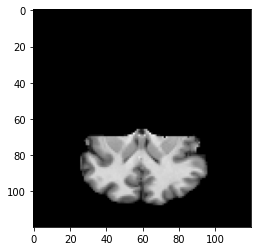

In [44]:
import matplotlib.pyplot as plt
import matplotlib.cbook as cbook
import cv2

i= 1
fig, ax = plt.subplots(num="MRI_demo")
ax.imshow(X_axial_train[i, : , :, 0], cmap="gray")
print(X_axial_train[i, : , :, 0].sum())
plt.show()

###VGG19

In [45]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping
import tensorflow as tf

In [46]:
model = Sequential()
model.add(Conv2D(input_shape=(120,120,1),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(Dropout(0.4))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Dropout(0.6))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Dropout(0.8))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Dropout(0.8))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Dropout(0.4))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

#Dense layer
model.add(Flatten())
model.add(Dense(units=4096,activation="relu"))
model.add(Dense(units=4096,activation="relu"))
model.add(Dense(units=1000,activation="relu"))
model.add(Dense(1, activation="softmax"))

model.compile(optimizer='adam', loss=keras.losses.binary_crossentropy, metrics=['accuracy'])

print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_32 (Conv2D)           (None, 120, 120, 64)      640       
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 120, 120, 64)      36928     
_________________________________________________________________
dropout_10 (Dropout)         (None, 120, 120, 64)      0         
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 60, 60, 64)        0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 60, 60, 128)       73856     
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 60, 60, 128)       147584    
_________________________________________________________________
dropout_11 (Dropout)         (None, 60, 60, 128)      

In [47]:
checkpoint = ModelCheckpoint("vgg19_30slices.h5", monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_acc', min_delta=0, patience=20, verbose=1, mode='auto')
#fit_generator(steps_per_epoch=1,generator=traindata, validation_data= testdata, validation_steps=1,epochs=50,callbacks=[checkpoint])
# hist = model.fit(traindata, testdata, batch_size=10, epochs=20, verbose=0, shuffle=True,validation_split=0.2,callbacks=[checkpoint])

In [48]:
hist = model.fit(X_axial_train, y_axial_train, batch_size=10,epochs=30,validation_split=0.2, callbacks=[checkpoint])

Epoch 1/30
559/559 [==============================] - 1667s 3s/step - loss: nan - accuracy: 0.6526 - val_loss: nan - val_accuracy: 0.6786

Epoch 00001: val_accuracy improved from -inf to 0.67860, saving model to vgg19_30slices.h5
Epoch 2/30
559/559 [==============================] - 1719s 3s/step - loss: nan - accuracy: 0.6603 - val_loss: nan - val_accuracy: 0.6786

Epoch 00002: val_accuracy did not improve from 0.67860
Epoch 3/30
559/559 [==============================] - 1660s 3s/step - loss: nan - accuracy: 0.6603 - val_loss: nan - val_accuracy: 0.6786

Epoch 00003: val_accuracy did not improve from 0.67860
Epoch 4/30
559/559 [==============================] - 1666s 3s/step - loss: nan - accuracy: 0.6603 - val_loss: nan - val_accuracy: 0.6786

Epoch 00004: val_accuracy did not improve from 0.67860
Epoch 5/30
559/559 [==============================] - 1662s 3s/step - loss: nan - accuracy: 0.6603 - val_loss: nan - val_accuracy: 0.6786

Epoch 00005: val_accuracy did not improve from 0.

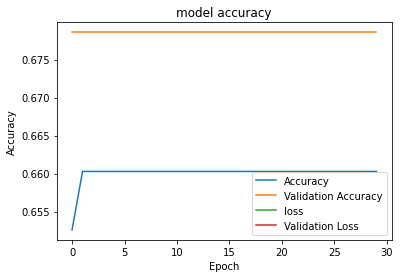

In [49]:
import matplotlib.pyplot as plt

plt.plot(hist.history["accuracy"])
plt.plot(hist.history['val_accuracy'])
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy","loss","Validation Loss"])
plt.show()

In [50]:
test_results = model.evaluate(X_axial_test, y_axial_test)
test_results

57/57 [==============================] - 112s 2s/step - loss: nan - accuracy: 0.6642


[nan, 0.664249837398529]

# CORONAL

In [20]:
X_coronal_train, y_coronal_train = get_slices_per_group_coronal(X_train, y_train)
X_coronal_train = X_coronal_train.reshape(-1, X_coronal_train.shape[1], X_coronal_train.shape[2], 1)

-> [1/173] Slices processed 67.
-> [2/173] Slices processed 134.
-> [3/173] Slices processed 160.
-> [4/173] Slices processed 227.
-> [5/173] Slices processed 294.
-> [6/173] Slices processed 361.
-> [7/173] Slices processed 428.
-> [8/173] Slices processed 495.
-> [9/173] Slices processed 562.
-> [10/173] Slices processed 629.
-> [11/173] Slices processed 696.
-> [12/173] Slices processed 763.
-> [13/173] Slices processed 830.
-> [14/173] Slices processed 897.
-> [15/173] Slices processed 964.
-> [16/173] Slices processed 1031.


C:\Users\josie\AppData\Local\Temp/ipykernel_22212/1790016269.py:22: RuntimeWarning: invalid value encountered in true_divide
  arr = arr / arr.max()


-> [17/173] Slices processed 1212.
-> [18/173] Slices processed 1279.
-> [19/173] Slices processed 1346.
-> [20/173] Slices processed 1413.
-> [21/173] Slices processed 1480.
-> [22/173] Slices processed 1547.
-> [23/173] Slices processed 1570.
-> [24/173] Slices processed 1637.
-> [25/173] Slices processed 1704.
-> [26/173] Slices processed 1771.
-> [27/173] Slices processed 1838.
-> [28/173] Slices processed 1905.
-> [29/173] Slices processed 1972.
-> [30/173] Slices processed 2039.
-> [31/173] Slices processed 2106.
-> [32/173] Slices processed 2173.
-> [33/173] Slices processed 2240.
-> [34/173] Slices processed 2307.
-> [35/173] Slices processed 2374.
-> [36/173] Slices processed 2441.
-> [37/173] Slices processed 2508.
-> [38/173] Slices processed 2575.
-> [39/173] Slices processed 2642.
-> [40/173] Slices processed 2709.
-> [41/173] Slices processed 2776.
-> [42/173] Slices processed 2843.
-> [43/173] Slices processed 2910.
-> [44/173] Slices processed 2977.
-> [45/173] Slices p

In [21]:
X_coronal_test, y_coronal_test = get_slices_per_group_coronal(X_test, y_test)
X_coronal_test = X_coronal_test.reshape(-1, X_coronal_train.shape[1], X_coronal_train.shape[2], 1)

-> [1/44] Slices processed 67.
-> [2/44] Slices processed 134.
-> [3/44] Slices processed 198.
-> [4/44] Slices processed 265.
-> [5/44] Slices processed 332.
-> [6/44] Slices processed 399.
-> [7/44] Slices processed 466.
-> [8/44] Slices processed 533.
-> [9/44] Slices processed 600.
-> [10/44] Slices processed 667.
-> [11/44] Slices processed 734.
-> [12/44] Slices processed 801.
-> [13/44] Slices processed 868.
-> [14/44] Slices processed 935.
-> [15/44] Slices processed 1002.
-> [16/44] Slices processed 1069.
-> [17/44] Slices processed 1136.
-> [18/44] Slices processed 1203.
-> [19/44] Slices processed 1270.
-> [20/44] Slices processed 1337.
-> [21/44] Slices processed 1404.
-> [22/44] Slices processed 1471.
-> [23/44] Slices processed 1538.
-> [24/44] Slices processed 1605.
-> [25/44] Slices processed 1672.
-> [26/44] Slices processed 1739.
-> [27/44] Slices processed 1806.
-> [28/44] Slices processed 1873.
-> [29/44] Slices processed 1940.
-> [30/44] Slices processed 2007.
-> [

In [22]:
print("Train: X:(%d, %d, %d, %d), y: %d" %(X_coronal_train.shape[0],X_coronal_train.shape[1],X_coronal_train.shape[2],X_coronal_train.shape[3], len(y_coronal_train)))
print("Test: X:(%d, %d, %d, %d), y: %d" %(X_coronal_test.shape[0],X_coronal_test.shape[1],X_coronal_test.shape[2],X_coronal_test.shape[3], len(y_coronal_test)))

Train: X:(11556, 224, 224, 1), y: 11556
Test: X:(2945, 224, 224, 1), y: 2945


# VGG19

In [16]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping
import imageio
import tensorflow as tf

In [23]:
model = Sequential()
model.add(Conv2D(input_shape=(224,224,1),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(Dropout(0.4))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Dropout(0.6))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Dropout(0.8))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Dropout(0.8))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Dropout(0.4))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

#Dense layer
model.add(Flatten())
model.add(Dense(units=4096,activation="relu"))
model.add(Dense(units=4096,activation="relu"))
model.add(Dense(units=1000,activation="relu"))
model.add(Dense(1, activation="softmax"))

model.compile(optimizer='adam', loss=keras.losses.binary_crossentropy, metrics=['accuracy'])

print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 224, 224, 64)      640       
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 224, 224, 64)      36928     
_________________________________________________________________
dropout_5 (Dropout)          (None, 224, 224, 64)      0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 112, 112, 128)     147584    
_________________________________________________________________
dropout_6 (Dropout)          (None, 112, 112, 128)    

In [22]:
checkpoint = ModelCheckpoint("vgg19_coronal.h5", monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_acc', min_delta=0, patience=20, verbose=1, mode='auto')
#fit_generator(steps_per_epoch=1,generator=traindata, validation_data= testdata, validation_steps=1,epochs=50,callbacks=[checkpoint])
# hist = model.fit(traindata, testdata, batch_size=10, epochs=20, verbose=0, shuffle=True,validation_split=0.2,callbacks=[checkpoint])

In [ ]:
hist = model.fit(X_coronal_train, y_coronal_train, batch_size=10,epochs=50,validation_split=0.2, callbacks=[checkpoint])

Epoch 1/50
928/928 [==============================] - 8392s 9s/step - loss: nan - accuracy: 0.5174 - val_loss: nan - val_accuracy: 0.6246

Epoch 00001: val_accuracy improved from -inf to 0.62457, saving model to vgg19_coronal.h5
Epoch 2/50
928/928 [==============================] - 8386s 9s/step - loss: nan - accuracy: 0.5164 - val_loss: nan - val_accuracy: 0.6246

Epoch 00002: val_accuracy did not improve from 0.62457
Epoch 3/50
928/928 [==============================] - 8388s 9s/step - loss: nan - accuracy: 0.5164 - val_loss: nan - val_accuracy: 0.6246

Epoch 00003: val_accuracy did not improve from 0.62457
Epoch 4/50
928/928 [==============================] - 8408s 9s/step - loss: nan - accuracy: 0.5164 - val_loss: nan - val_accuracy: 0.6246

Epoch 00004: val_accuracy did not improve from 0.62457
Epoch 5/50
928/928 [==============================] - 8387s 9s/step - loss: nan - accuracy: 0.5164 - val_loss: nan - val_accuracy: 0.6246

Epoch 00005: val_accuracy did not improve from 0.6

In [ ]:
import matplotlib.pyplot as plt

plt.plot(hist.history["accuracy"])
plt.plot(hist.history['val_accuracy'])
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy","loss","Validation Loss"])
plt.show()

In [24]:
model.load_weights("./vgg19_coronal.h5")
test_results = model.evaluate(X_coronal_test, y_coronal_test)
test_results

93/93 [==============================] - 561s 6s/step - loss: 0.6890 - accuracy: 0.4540


[0.6889810562133789, 0.45398980379104614]

# Sagital

In [34]:
X_sagital_train, y_sagital_train = get_slices_per_group_sagital(X_train, y_train)
X_sagital_train = X_sagital_train.reshape(-1, X_sagital_train.shape[1], X_sagital_train.shape[2], 1)

-> [1/214] Slices processed 153.


ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 3 dimension(s) and the array at index 1 has 0 dimension(s)

In [ ]:
print("Train: X:(%d, %d, %d, %d), y: %d" %(X_sagital_train.shape[0],X_sagital_train.shape[1],X_sagital_train.shape[2],X_sagital_train.shape[3], len(y_sagital_train)))
print("Test: X:(%d, %d, %d, %d), y: %d" %(X_sagital_test.shape[0],X_sagital_test.shape[1],X_sagital_test.shape[2],X_sagital_test.shape[3], len(y_sagital_test)))

#EXTRA

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.cbook as cbook
import cv2
img = sitk.ReadImage(PD_file_paths[1], sitk.sitkFloat64)
arr = sitk.GetArrayFromImage(img)
print(arr.shape, arr.min())

fig, ax = plt.subplots(num="MRI_demo")
ax.imshow(arr[38, : , :], cmap="gray")
plt.show()

In [ ]:
arr_reshaped = cv2.resize(arr[:, : , 100], (224, 224), interpolation=cv2.INTER_CUBIC)
arr_reshaped[arr_reshaped < 0] = 0
print(arr_reshaped.shape, arr_reshaped.min())

In [33]:
arr_reshaped[arr_reshaped < 0] = 0
print(arr_reshaped.shape, arr_reshaped.min())

NameError: name 'arr_reshaped' is not defined

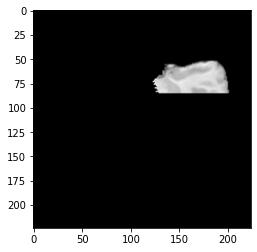

In [15]:
fig, ax = plt.subplots(num="MRI_demo")
ax.imshow(arr_reshaped, cmap="gray") 

plt.show()

In [5]:
BUY_file_paths =  sorted(glob("E:/ESPOL/integradora/images_preprocessed/BUY/*/ex_*.nii.gz"))  #68 files
EAT_file_paths =  sorted(glob("E:/ESPOL/integradora/images_preprocessed/EAT/*/ex_*.nii.gz")) #81files
GAMBLE_file_paths =  sorted(glob("E:/ESPOL/integradora/images_preprocessed/GAMBLE/*/ex_*.nii.gz"))  #7 files
SEX_file_paths =  sorted(glob("E:/ESPOL/integradora/images_preprocessed/SEX/*/ex_*.nii.gz"))  #42 files

PD_file_paths =  sorted(glob("E:/ESPOL/integradora/images_preprocessed/PD/*/ex_*.nii.gz"))  #100 files

NameError: name 'glob' is not defined

In [6]:
print(len(BUY_file_paths), BUY_file_paths[:3])
print(len(EAT_file_paths), EAT_file_paths[:3])
print(len(GAMBLE_file_paths), GAMBLE_file_paths[:3])
print(len(SEX_file_paths), SEX_file_paths[:3])

print(len(PD_file_paths), PD_file_paths[:3])

NameError: name 'BUY_file_paths' is not defined

In [3]:
import os
import shutil
import subprocess

In [4]:
destiny = "E:/ESPOL/integradora/desorders/PREPROCESSED/" + "BUY/"

for file in BUY_file_paths:
    id = file.split("\\")[1]
    shutil.copyfile(file, destiny + id + ".nii.gz")

NameError: name 'BUY_file_paths' is not defined